In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set_style("ticks")

rseed = 20090425
np.random.seed(rseed)

In [2]:
sns.set_style("ticks")

Import relevant data from KQ4 spreadsheet.

In [3]:
keep_columns = ['Author', 'Year', 'Refid', 'Pre-op', 'Initial Surgery', 'Morcellation',
       'Power', 'Upstaged', 'Months follow-up', 'First_\nstaging',
       'Median_\nFUP_time', 'Range_\nFUP_Time', 'Outcome', 'Age',
       'Menopausal Status', 'Lost_to_Fup', 'Include', 'Inclusion staging criteria restricted or not (y/n)']

kq4_data = (pd.read_excel('data/UF_KQ4_data_for_Chris_12142016_SK.xlsx', sheetname='All_KQ4_data_Original', 
                         na_values=['NR', 'NA'])[keep_columns]
                .rename(columns={'Months follow-up': 'fup_months',
                               'Median_\nFUP_time': 'fup_median', 
                               'Range_\nFUP_Time': 'fup_range',
                                'Pre-op': 'preop', 
                                 'Initial Surgery': 'surgery_init',
                                'Menopausal Status': 'menop_status',
                                'Inclusion staging criteria restricted or not (y/n)': 'stage_include'}))

kq4_data.columns = kq4_data.columns.str.lower()

In [4]:
benign = kq4_data.preop=='Benign'
not_benign_and_stage1 = (kq4_data.preop!='Benign') & (kq4_data['first_\nstaging']=='I')
not_yellow = (kq4_data.include==1)
not_lost = kq4_data.lost_to_fup!='yes'

kq4_data = kq4_data[not_lost 
                    & not_yellow 
                    & (benign | not_benign_and_stage1)].drop(['include', 'lost_to_fup'], axis=1)

In [5]:
kq4_data.refid.unique()

array([405, 753, 750, 145, 13, 38, 394, 783, 826, 211, 811, 841, 752, 364,
       286, 1807, 1917, 1539, 1811, 2024, 932, 2114], dtype=object)

Distribution of age (if not missing)

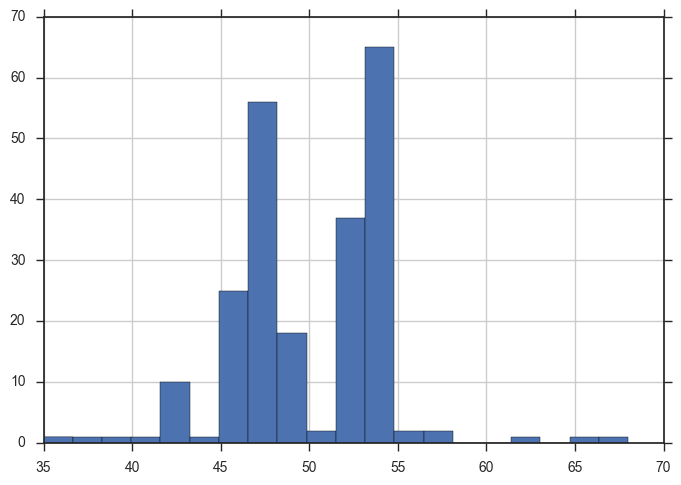

In [6]:
kq4_data.age.hist(bins=20)

Note that half the ages are missing:

In [7]:
kq4_data.isnull().mean().round(2)

author             0.00
year               0.00
refid              0.00
preop              0.08
surgery_init       0.00
morcellation       0.00
power              0.09
upstaged           0.69
fup_months         0.00
first_\nstaging    0.05
fup_median         0.33
fup_range          0.33
outcome            0.00
age                0.49
menop_status       0.76
stage_include      0.01
dtype: float64

In [8]:
kq4_data.groupby('refid').year.max().value_counts()

2016.0    6
2015.0    6
2008.0    2
2014.0    2
2010.0    1
2013.0    1
1999.0    1
2009.0    1
2011.0    1
2012.0    1
Name: year, dtype: int64

Drop those with missing `power` or `morcellation` covariates. Perhaps we can impute later.

In [9]:
kq4_data = kq4_data.dropna(subset=['morcellation', 'power']).reset_index(drop=True)

Values are a mess in several columns:

In [10]:
kq4_data.outcome.value_counts()

Alive    167
Dead      62
alive     52
dead      46
AWD       30
NED       23
Died      22
Name: outcome, dtype: int64

In [11]:
kq4_data['preop'].value_counts()

benign     193
Benign     169
sarcoma      3
Name: preop, dtype: int64

In [12]:
kq4_data.outcome = kq4_data.outcome.replace({'Alive': 'alive',
                         'Dead': 'dead',
                         'AWD': 'awd',
                         'NED': 'ned',
                         'Died': 'dead'})
kq4_data.outcome.value_counts()

alive    219
dead     130
awd       30
ned       23
Name: outcome, dtype: int64

In [13]:
kq4_data.preop = kq4_data.preop.str.strip().replace({'Benign': 'benign'})
kq4_data['preop'].value_counts()

benign     362
sarcoma      3
Name: preop, dtype: int64

This is also a mess. Need to fix.

In [14]:
pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,No,Yes,no,yes
morcellation,,,,
No,261,0,0,0
Yes,38,43,24,0
no,0,0,2,0
yes,13,0,0,21


In [15]:
kq4_data.morcellation = kq4_data.morcellation.str.lower()
kq4_data.power = kq4_data.power.str.lower()

pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,no,yes
morcellation,,
no,263,0
yes,75,64


Create death outcome column

In [16]:
kq4_data['died'] = (kq4_data.outcome=='dead').astype(int)
kq4_data.died.value_counts()

0    272
1    130
Name: died, dtype: int64

In [17]:
kq4_data.head(20)

,author,year,refid,preop,surgery_init,morcellation,power,upstaged,fup_months,first_ staging,fup_median,fup_range,outcome,age,menop_status,stage_include,died
0,Einstein,2008.0,405,benign,LSC SCH,yes,yes,No,30.0,I,NaN,NaN,ned,NaN,NaN,No,0
1,Einstein,2008.0,405,benign,LMYOM,yes,yes,Yes,61.0,I,NaN,NaN,ned,NaN,NaN,No,0
2,Einstein,2008.0,405,benign,SCH,yes,no,Yes,31.0,I,NaN,NaN,awd,NaN,NaN,No,0
3,Einstein,2008.0,405,benign,SCH BSO,no,no,No,37.0,I,NaN,NaN,ned,NaN,NaN,No,0
4,Einstein,2008.0,405,benign,SCH BSO,no,no,Yes,6.0,I,NaN,NaN,awd,NaN,NaN,No,0
5,Kamikabeya,2010.0,753,benign,TAH BSO,no,no,No,2.0,NaN,NaN,NaN,dead,58.0,Post,No,1
6,Takamizawa,1999.0,750,benign,TAH,no,no,NaN,132.0,NaN,NaN,NaN,ned,44.0,NaN,NaN,0
7,Oduyebo,2014.0,145,benign,LSC SCH,yes,yes,No,27.0,I,NaN,NaN,ned,NaN,NaN,No,0
8,Oduyebo,2014.0,145,benign,LSC SCH,yes,yes,No,38.0,I,NaN,NaN,ned,NaN,NaN,No,0
9,Oduyebo,2014.0,145,benign,LMYOM,yes,yes,No,48.7,I,NaN,NaN,ned,NaN,NaN,No,0


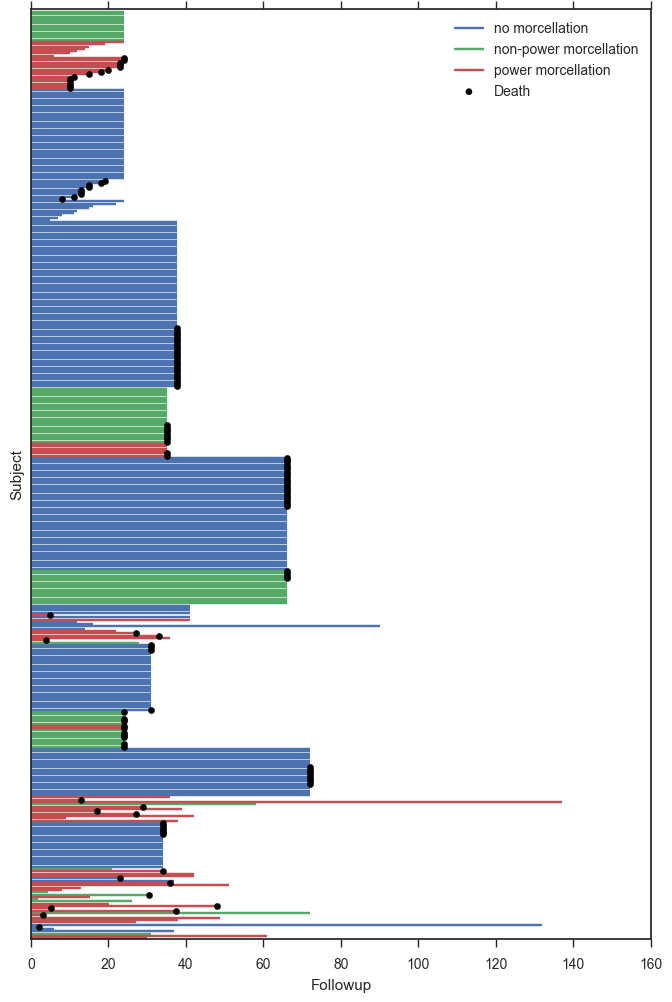

In [18]:
fig, ax = plt.subplots(figsize=(8, 12))
n_patients = kq4_data.shape[0]

time = kq4_data.fup_months

ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

blue, green, red = sns.color_palette()[:3]

ax.hlines(kq4_data.index[ix0], 0, time[ix0],
          color=blue, label='no morcellation')

ax.hlines(kq4_data.index[ix1], 0, time[ix1],
          color=green, label='non-power morcellation')

ax.hlines(kq4_data.index[ix2], 0, time[ix2],
          color=red, label='power morcellation')

ax.scatter(time[kq4_data.died == 1], kq4_data.index[kq4_data.died == 1],
           color='k', zorder=10, label='Death');

ax.set_xlim(left=0)
ax.set_ylabel('Subject')
ax.set_xlabel('Followup')
ax.set_yticks([])

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='upper right');

In [19]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [20]:
kmf.fit(kq4_data.fup_months, event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 402 observations, 272 censored>

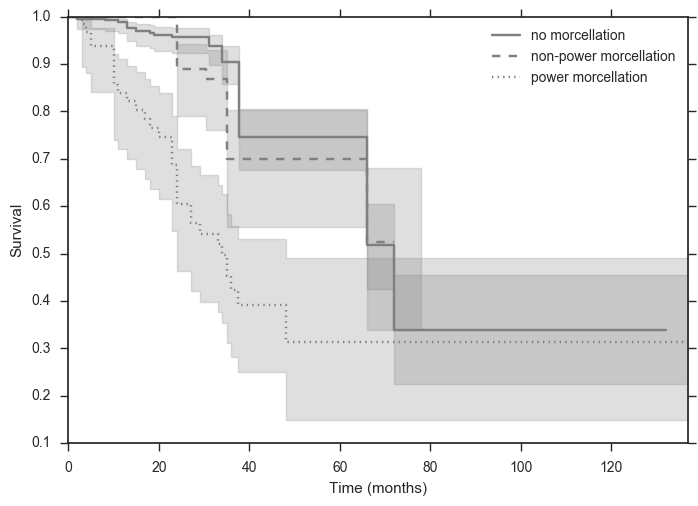

In [42]:
time = kq4_data.fup_months
event = event_observed=kq4_data.died
ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot(color='grey')

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax, ls='dashed', color='grey')

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax, ls='dotted', color='grey')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival')

In [46]:
from lifelines import NelsonAalenFitter
naf_baseline = NelsonAalenFitter()
naf_baseline.fit(time[ix0], event[ix0], label='no morcellation')

naf_non_power = NelsonAalenFitter()
naf_non_power.fit(time[ix1], event[ix1], label='non-power morcellation')

naf_power = NelsonAalenFitter()
naf_power.fit(time[ix2], event[ix2], label='power morcellation')

<lifelines.NelsonAalenFitter: fitted with 64 observations, 32 censored>

In [82]:
hazard_baseline = naf_baseline.cumulative_hazard_.loc[41][0]

In [71]:
E_none = naf_baseline.event_table.loc[0].at_risk - naf_baseline.event_table.loc[41].at_risk

In [81]:
hazard_power = naf_power.cumulative_hazard_.loc[48.7][0]
hazard_power

1.1217095023199819

In [72]:
E_power = naf_power.event_table.loc[0].at_risk - naf_power.event_table.loc[48.7].at_risk

In [83]:
hr = hazard_power/hazard_baseline
hr

3.8588008943823517

In [73]:
SE = np.sqrt(1/E_none + 1/E_power)
SE

0.14846888816411394

In [84]:
half_interval = 1.96 * SE

In [86]:
np.exp(np.log(hr) - half_interval), np.exp(np.log(hr) + half_interval)

(2.8845169914138973, 5.1621621182363961)

Some studies show event time truncated to the end of the followup period. These values should be treated as **missing** and their values imputed from the range of possible followup times.

In [22]:
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_months'] = np.nan

In [23]:
kq4_data['fup_min'] = 0
kq4_data['fup_max'] = kq4_data.fup_months.max()

fup_min, fup_max = np.transpose([[float(x[0]), float(x[1])] for x in kq4_data.fup_range[kq4_data.fup_median.notnull()].str.split('-')])

If the event was a death event, make the `fup_min` equal to zero.

In [24]:
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_min'] = fup_min * ((1-kq4_data.died)[kq4_data.fup_median.notnull()])
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_max'] = fup_max

Summarize proportion of missing values

In [25]:
kq4_data.isnull().mean().round(2)

author             0.00
year               0.00
refid              0.00
preop              0.09
surgery_init       0.00
morcellation       0.00
power              0.00
upstaged           0.68
fup_months         0.64
first_\nstaging    0.06
fup_median         0.36
fup_range          0.36
outcome            0.00
age                0.54
menop_status       0.80
stage_include      0.01
died               0.00
fup_min            0.00
fup_max            0.00
dtype: float64

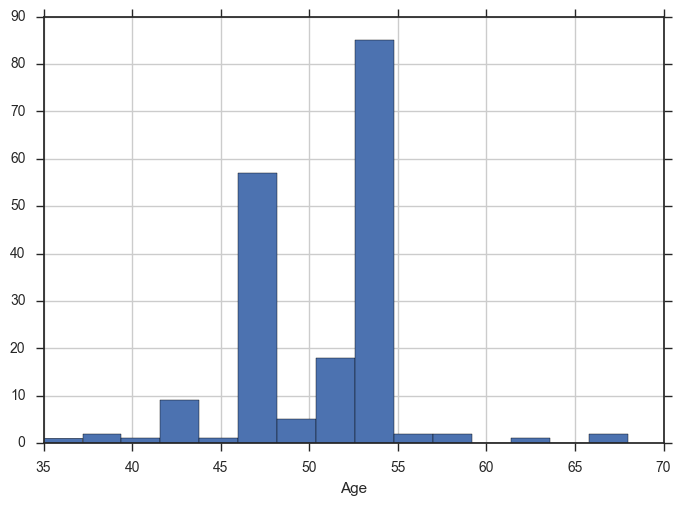

In [26]:
axes = kq4_data.age.hist(bins=15)
axes.set_xlabel('Age')

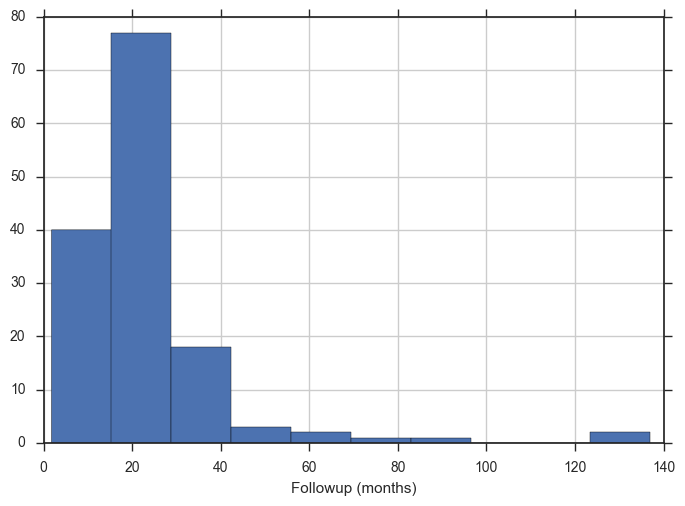

In [27]:
axes = kq4_data['fup_months'].hist()
axes.set_xlabel('Followup (months)')

In [63]:
kq4_data.groupby('refid').year.min()

refid
13      2015.0
38      2014.0
145     2014.0
211     2012.0
286     2011.0
364     2009.0
394     2008.0
405     2008.0
750     1999.0
752     2013.0
753     2010.0
783     2015.0
811     2015.0
826     2015.0
841     2015.0
932     2016.0
1539    2015.0
1807    2016.0
1811    2016.0
1917    2016.0
2024    2016.0
2114    2016.0
Name: year, dtype: float64

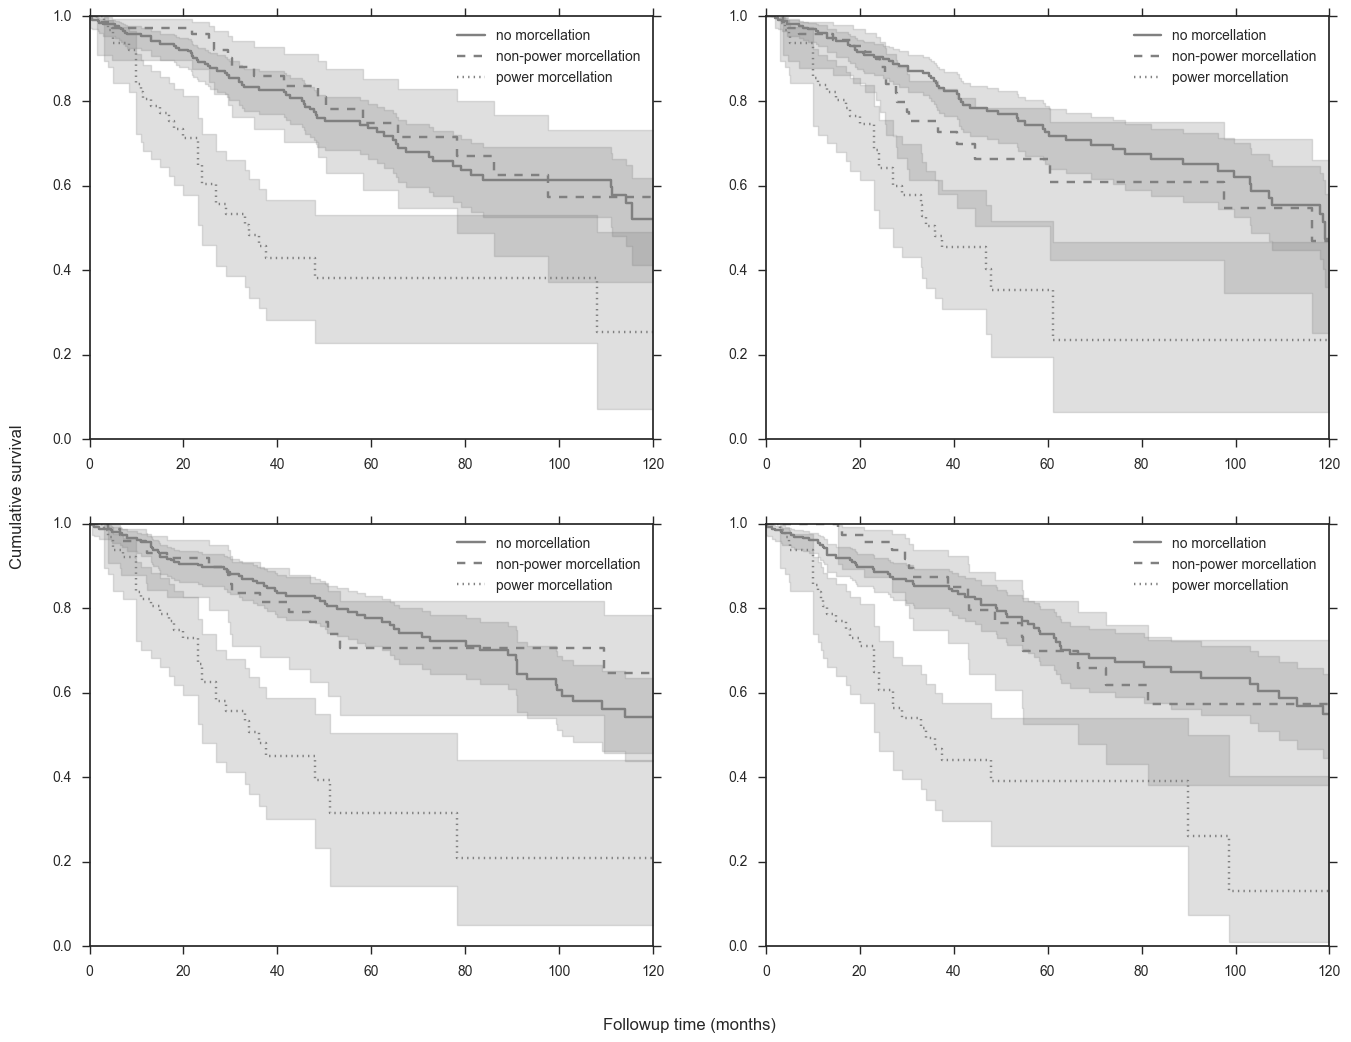

In [28]:
fig, axes = plt.subplots(2,2,figsize=(16,12))

for ax in axes.flatten():
    
    time_sim = kq4_data.fup_months.copy()
    event = event_observed=kq4_data.died
    missing_times = kq4_data.fup_months.isnull()
    time_sim.loc[missing_times] = np.random.uniform(kq4_data.fup_min[missing_times] * ((1-kq4_data.died)[missing_times]),
                                                    kq4_data.fup_max[missing_times])
    
    ix0 = kq4_data.morcellation=='no'
    ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
    ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

    kmf = KaplanMeierFitter()
    kmf.fit(time_sim[ix0], event[ix0], label='no morcellation')
    kmf.plot(ax=ax, color='grey')

    kmf.fit(time_sim[ix1], event[ix1], label='non-power morcellation')
    kmf.plot(ax=ax, ls='dashed', color='grey')

    kmf.fit(time_sim[ix2], event[ix2], label='power morcellation')
    kmf.plot(ax=ax, ls='dotted', color='grey')
    
    ax.set_xlim(0, 120)
    ax.set_xlabel('')

fig.text(0.5, 0.06, 'Followup time (months)', ha='center', va='center')
fig.text(0.08, 0.5, 'Cumulative survival', ha='center', va='center', rotation='vertical')

In [29]:
model_data = (kq4_data.assign(non_power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='no'))
                      .assign(power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='yes')))

In [30]:
time = model_data['fup_months']
event = event_observed = model_data.died.astype(int)
n_intervals = int(time.max()+1)
n_patients = model_data.shape[0]
refid = model_data.refid.values

In [31]:
time_missing = model_data['fup_months'].copy()
time_missing[time_missing.isnull()] = 1
time_masked = np.ma.masked_values(time_missing, value=1)

#non_power, power = model_data[['non_power_morcellation', 'power_morcellation']].values.astype(int).T
power = (model_data.power=='yes').astype(int)
morcellation = (model_data.morcellation=='yes').astype(int)

In [32]:
fup_min, fup_max = model_data[['fup_min', 'fup_max']].T.values

The study IDs used in the analyis:

In [33]:
studies = model_data.refid.unique()
studies

array([405, 753, 750, 145, 13, 38, 394, 783, 826, 211, 811, 841, 752, 364,
       286, 1807, 1917, 1539, 1811, 2024, 932, 2114], dtype=object)

In [34]:
study_ind = np.array([np.where(studies==id)[0][0] for id in refid])

In [35]:
from pymc3 import Normal, Deterministic, sample, HalfCauchy, Model, DensityDist, Metropolis, Potential, Exponential, Uniform
from pymc3 import traceplot, forestplot, summary, sample_ppc
import theano.tensor as tt

In [36]:
with Model() as exp_model:

    # Study random effect
    μ = Normal('μ', 0, sd=100)
    σ = pm.Uniform('σ', 0, 100)
    ζ = pm.Normal('ζ', 0, 1, shape=len(studies))
    θ = (μ + ζ*σ)[study_ind]

    # Effects of morcellation and power
    β = Normal('β', mu=0.0, sd=100, shape=2)

    # Survival rates
    λ = Deterministic('λ', tt.exp(θ + β[0] * morcellation + β[1] * power))
    
    # Impute missing event times
#     time_imputed = Exponential('time_imputed', lam=λ, observed=time_masked)
    time_imputed = Uniform('time_imputed', lower=fup_min, upper=fup_max, observed=time_masked)
    
    # Impose bound on missing times
    fup_bound = Potential('fup_bound', Uniform.dist(lower=fup_min, upper=fup_max).logp(time_imputed))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * tt.log(λ) - λ * time_imputed

    survival = DensityDist('survival', logp, observed={'event':event})


In [37]:
n_iterations = 200000
n_burn = 100000

In [38]:
with exp_model:
    start = {'time_imputed_missing': np.random.uniform((model_data.fup_min)[model_data.fup_months.isnull()],
                                                      (model_data.fup_max)[model_data.fup_months.isnull()])}
    exp_trace = sample(n_iterations, step=Metropolis(), start=start, random_seed=rseed)

100%|██████████| 200000/200000 [01:50<00:00, 1815.80it/s]


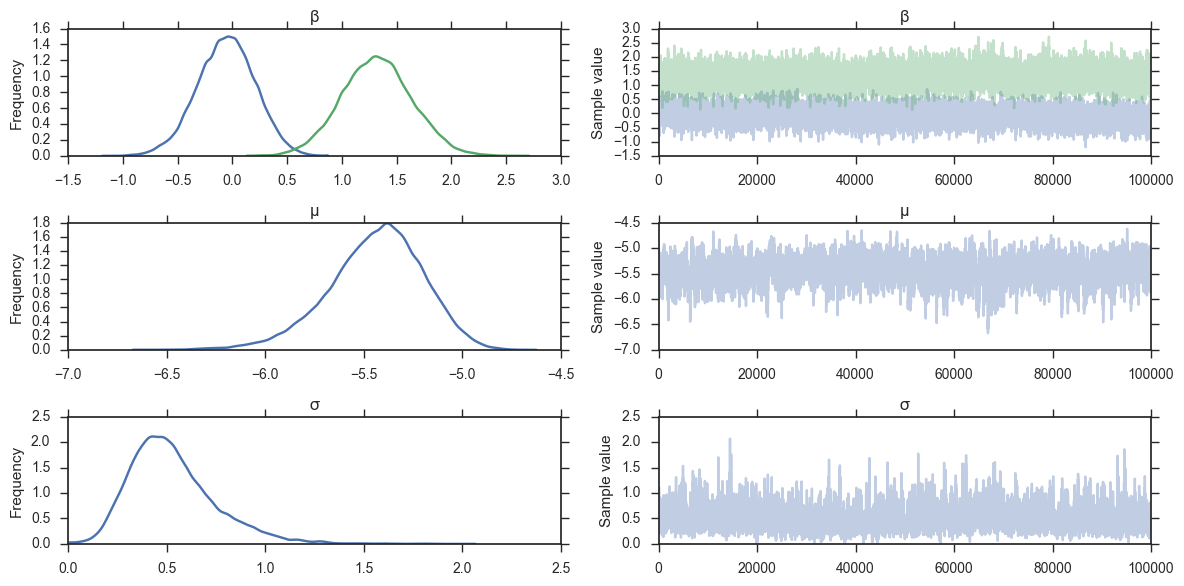

In [39]:
traceplot(exp_trace[n_burn:], varnames=['β', 'μ', 'σ']);

In [40]:
summary(exp_trace[n_burn:], varnames=['β'])


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.062           0.264            0.007            [-0.595, 0.442]
  1.315            0.322            0.008            [0.704, 1.958]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.596         -0.238         -0.056         0.118          0.441
  0.691          1.098          1.312          1.526          1.949



Imputed follow-up times

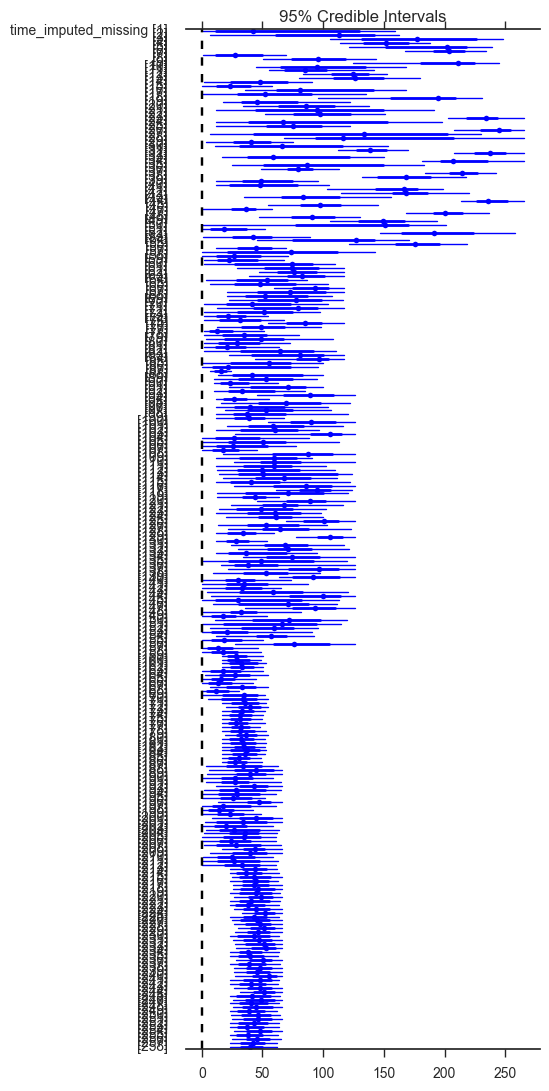

In [41]:
plt.figure(figsize=(6,12))
forestplot(exp_trace, varnames=['time_imputed_missing'])

In [42]:
# baseline_hazard = np.exp(exp_trace['β'][n_burn:, 0])
# non_power_hazard = np.exp(exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1])
# power_hazard = np.exp(exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1] + exp_trace['β'][n_burn:, 2])

In [43]:
baseline_hazard = np.exp(exp_trace['μ'][n_burn:])
non_power_hazard = np.exp(exp_trace['μ'][n_burn:] + exp_trace['β'][n_burn:, 0])
power_hazard = np.exp(exp_trace['μ'][n_burn:] + exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1])

Since this is a constant-hazard model, we can easily summarize the hazard estimates.

In [44]:
hazard_df = pd.DataFrame({'baseline':baseline_hazard, 'non-power':non_power_hazard, 'power':power_hazard})
hazard_df.describe(percentiles=[0.025, 0.975]).T[['mean', '2.5%', '97.5%']].round(4)

,mean,2.5%,97.5%
baseline,0.0045,0.0026,0.0066
non-power,0.0043,0.0021,0.0073
power,0.0157,0.0089,0.0242


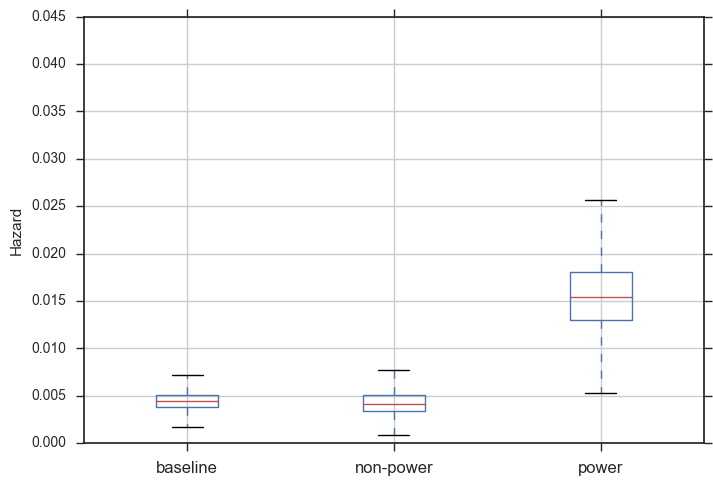

In [45]:
hazard_df.boxplot()
plt.ylabel('Hazard');

In [46]:
def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [47]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05, **kwargs):

    mean = f(hazard.mean(axis=0), **kwargs)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard, **kwargs), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean.squeeze(), color=color, label=label);

In [48]:
interval_bounds = np.arange(0, time.max() + 2, 1)

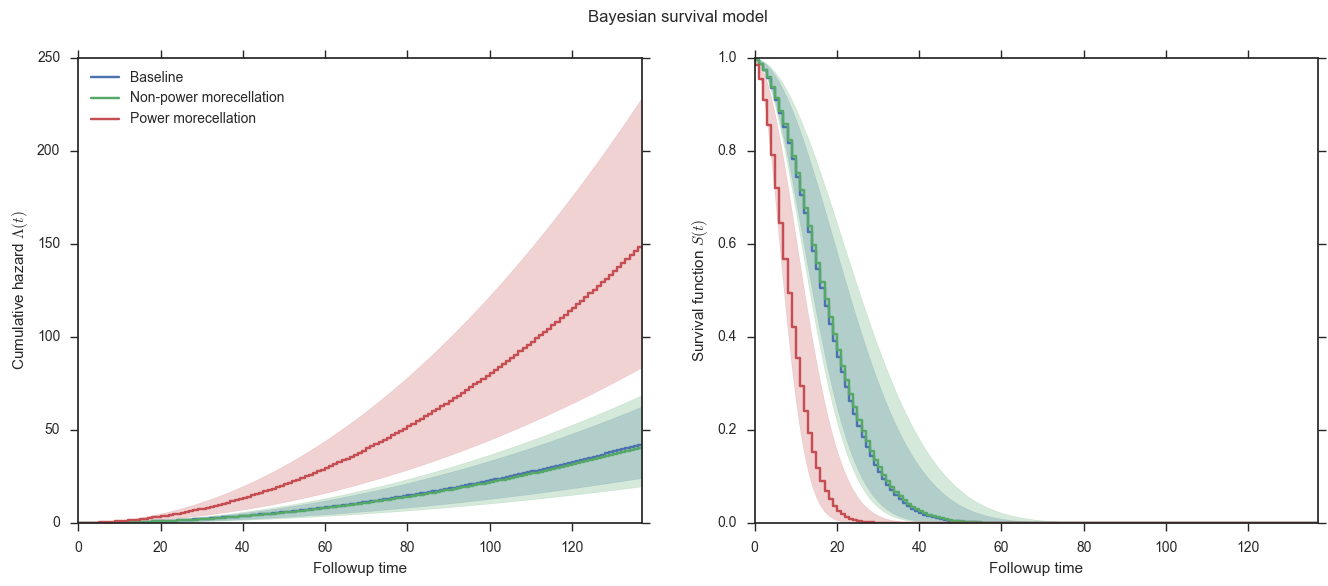

In [49]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_hazard, cum_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_hazard, cum_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_hazard, cum_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, time.max());
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_hazard, survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, time.max());
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

Unfortunately, the exponential (*i.e.* constant hazard) model does not seem to fit the data, based on the comparison between the K-M curves and the survival function. 

Below, we try a Weibull model for the survival function.

## Weibull survival model

In [50]:
model_data.refid.unique()

array([405, 753, 750, 145, 13, 38, 394, 783, 826, 211, 811, 841, 752, 364,
       286, 1807, 1917, 1539, 1811, 2024, 932, 2114], dtype=object)

In [51]:
from pymc3 import Weibull, df_summary

In [52]:
with Model() as weibull_model:

    # Study random effect
    μ = Normal('μ', 0, sd=10)
    σ = pm.HalfCauchy('σ', 2.5)
    ζ = pm.Normal('ζ', 0, 1, shape=len(studies))
    θ = (μ + ζ*σ)[study_ind]

    # Weibull shape parameter
    k = pm.HalfCauchy('k', 2.5)
    # Effects of morcellation and power
    β = Normal('β', mu=0.0, sd=10, shape=2)

    # Weibull scales
    λ = Deterministic('λ', tt.exp(θ + β[0] * morcellation + β[1] * power))
    
    # Impute missing event times
#     time_imputed = Weibull('time_imputed', k, λ, observed=time_masked)
    time_imputed = Uniform('time_imputed', lower=fup_min, upper=fup_max, observed=time_masked)

    
    # Impose bound on missing times
    fup_bound = Potential('fup_bound', Uniform.dist(lower=fup_min, upper=fup_max).logp(time_imputed))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * (tt.log(k/λ) + (k-1)*tt.log(time_imputed/λ)) - (time_imputed/λ)**k

    survival = DensityDist('survival', logp, observed={'event':event})


In [53]:
with weibull_model:
    start = {'time_imputed_missing': np.random.uniform((model_data.fup_min)[model_data.fup_months.isnull()],
                                                      (model_data.fup_max)[model_data.fup_months.isnull()])}
    weibull_trace = sample(n_iterations, step=Metropolis(), start=start, random_seed=rseed)

100%|██████████| 200000/200000 [03:00<00:00, 1108.06it/s]


In [54]:
summary(weibull_trace[n_burn:], varnames=['β']);


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.066            0.109            0.005            [-0.150, 0.279]
  -0.761           0.140            0.006            [-1.036, -0.487]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.148         -0.006         0.068          0.138          0.281
  -1.050         -0.851         -0.757         -0.666         -0.498



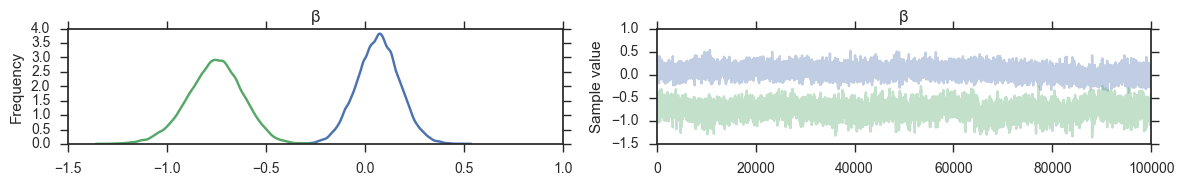

In [55]:
traceplot(weibull_trace[n_burn:], varnames=['β']);

Weibull shape parameter

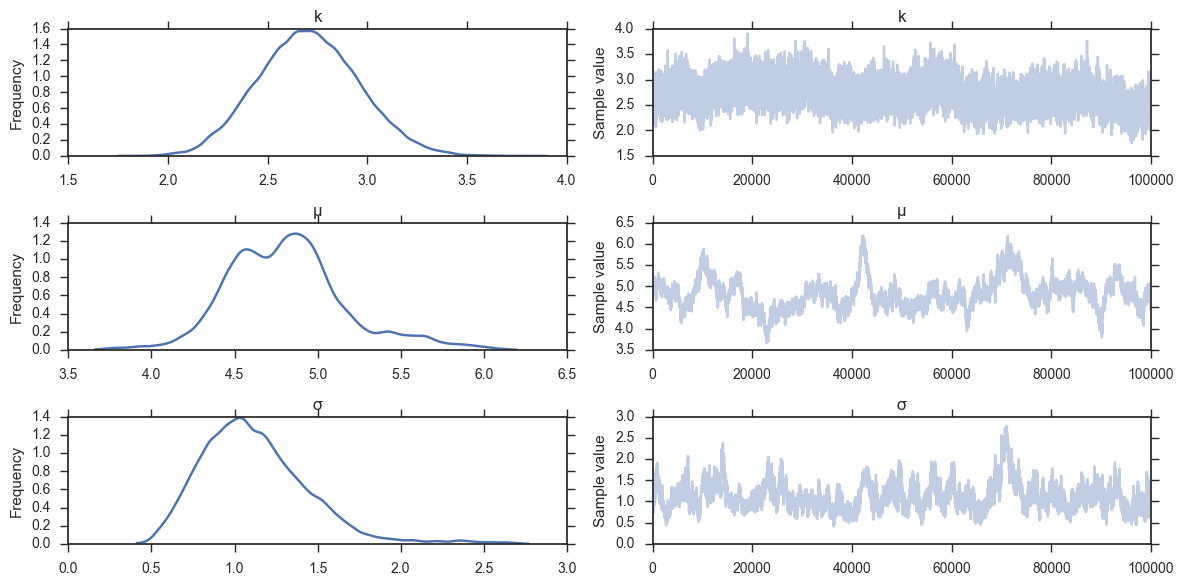

In [56]:
traceplot(weibull_trace[n_burn:], varnames=['k', 'μ', 'σ']);

In [57]:
baseline_lam = np.exp(weibull_trace['μ'][n_burn:])
non_power_lam = np.exp(weibull_trace['μ'][n_burn:] + weibull_trace['β'][n_burn:, 0])
power_lam = np.exp(weibull_trace['μ'][n_burn:] + weibull_trace['β'][n_burn:, 0] + weibull_trace['β'][n_burn:, 1])
k_trace = weibull_trace['k'][n_burn:]

In [58]:
n_intervals = 120
interval_bounds = np.arange(0, n_intervals + 1, 1)

In [59]:
def cum_weibull_hazard(lam, k=k_trace, t=n_intervals):
    return (k.reshape(-1,1)*(1/lam.reshape(-1,1))**k.reshape(-1,1) * np.arange(t)**(k.reshape(-1,1) - 1)).cumsum(axis=-1)

def weibull_survival(lam, k=k_trace, t=n_intervals):
    return np.exp(-cum_weibull_hazard(lam, k, t))

In [60]:
def plot_with_hpd(x, lam, f, ax, color=None, label=None, alpha=0.05, debug=False, **kwargs):

    m = np.median(f(lam, **kwargs), axis=0)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(lam, **kwargs), percentiles, axis=0)
    
    if debug:
        import pdb;pdb.set_trace()
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, m, color=color, label=label);

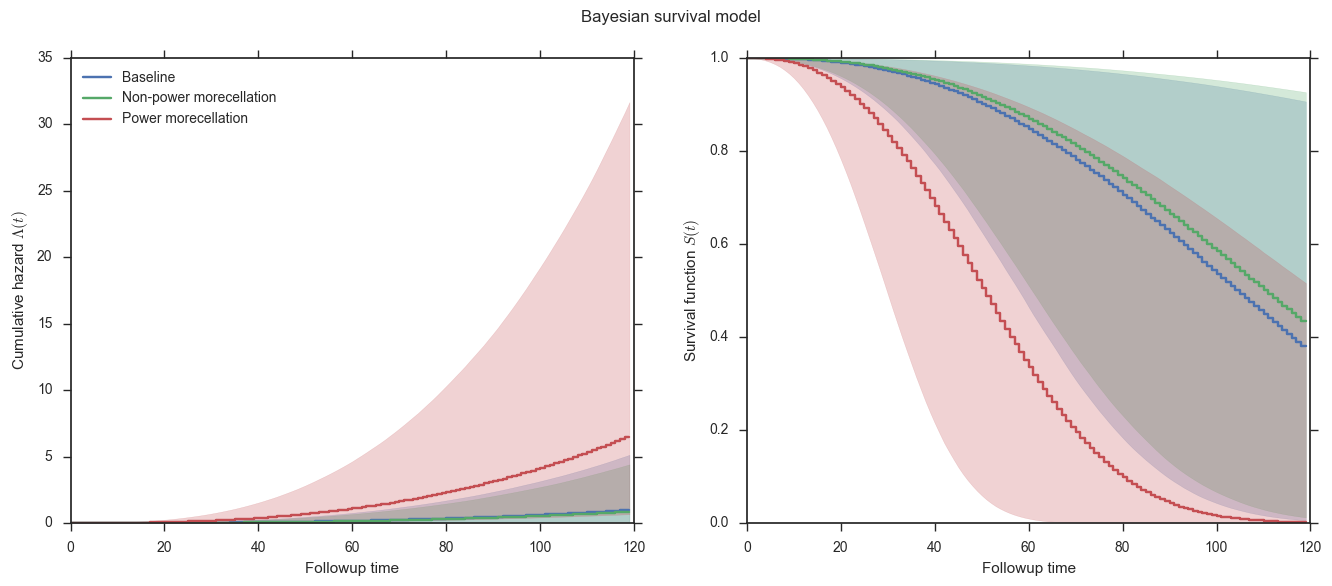

In [61]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_lam, cum_weibull_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_lam, cum_weibull_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_lam, cum_weibull_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, n_intervals);
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_lam, weibull_survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_lam, weibull_survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_lam, weibull_survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, n_intervals);
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

The above is a much more reasonable fit.

### Summary statistics

Time (months) at which mean survival is 0.5 for each subgroup:

In [62]:
baseline_survival = weibull_survival(baseline_lam)
non_power_survival = weibull_survival(non_power_lam)
power_survival = weibull_survival(power_lam)

In [63]:
np.where(baseline_survival.mean(axis=0)<=0.5)[0][0]

103

In [64]:
np.where(non_power_survival.mean(axis=0)<=0.5)[0][0]

110

In [65]:
np.where(power_survival.mean(axis=0)<=0.5)[0][0]

52

Proportion alive after 5 years

In [66]:
baseline_survival_5 = baseline_survival[:, 60]
non_power_survival_5 = non_power_survival[:, 60]
power_survival_5 = power_survival[:, 60]

In [67]:
print('Baseline 5-year median survival: {0} {1}'.format(np.median(baseline_survival), 
                                                        np.percentile(baseline_survival, [2.5, 97.5])))

Baseline 5-year median survival: 0.8808611312111201 [ 0.11224701  0.99996521]


In [68]:
print('Non-power morcellation median 5-year survival: {0} {1}'.format(np.median(non_power_survival_5), 
                                                        np.percentile(non_power_survival_5, [2.5, 97.5])))

Non-power morcellation median 5-year survival: 0.8744381343555603 [ 0.51073284  0.98744847]


In [69]:
print('Power morcellation median 5-year survival: {0} {1}'.format(np.median(power_survival_5), 
                                                        np.percentile(power_survival_5, [2.5, 97.5])))

Power morcellation median 5-year survival: 0.3508519950262359 [ 0.00963049  0.89461456]


Ratio of hazards at 5 years between power and non-power morecellation

In [70]:
def weibull_hazard(lam, t, k=k_trace):
    return (k.reshape(-1,1)*(1/lam.reshape(-1,1))**k.reshape(-1,1) * t**(k.reshape(-1,1) - 1))

In [71]:
non_power_hazard_5 = weibull_hazard(non_power_lam, 60).mean(axis=0)
non_power_hazard_5

array([ 0.00824894])

In [72]:
power_hazard_5 = weibull_hazard(power_lam, 60).mean(axis=0)
power_hazard_5

array([ 0.06133506])

In [73]:
hazard_ratio = weibull_hazard(power_lam, 60)/weibull_hazard(non_power_lam, 60)

In [74]:
print('Hazard ratio (power vs non-power) at 5 years: {0} {1}'.format(hazard_ratio.mean(), 
                                                                     np.percentile(hazard_ratio, [2.5, 97.5])))

Hazard ratio (power vs non-power) at 5 years: 8.349186964915262 [  3.71703019  16.35262061]
